In [1]:
%load_ext autoreload
%autoreload 2

# To load the environment variable defined in the .env file
# from dotenv import load_dotenv
# load_dotenv();

import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from scipy import stats
from scipy.ndimage import gaussian_filter 
from sklearn.neighbors import KernelDensity
import seaborn as sns
import plotly.graph_objects as go

C:\Users\anniw\anaconda3\envs\ift6758\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
season_year = 2017
season_type = "Regular"

In [4]:
cd 

C:\Users\anniw\IFT6758-A2022-G08


In [6]:
import src.data.NHLDataManager as DataManager
data_manager = DataManager.NHLDataManager(r'C:\Users\anniw\OneDrive - Universite de Montreal\MSc 2022-2024\IFT6758 Science des données\nhl_data_dir')

In [ ]:
game_numbers = data_manager.get_game_numbers_from_data(season_year=season_year, season_type=season_type)
data_season_df = data_manager.get_goals_and_shots_df_standardised(season_year=season_year, season_type=season_type, game_number=game_numbers[0])

for game_number in game_numbers[1:]:
    data_season_df = pd.concat([data_season_df, data_manager.get_goals_and_shots_df_standardised(season_year=season_year, season_type=season_type, game_number=game_number)], ignore_index=True)

In [431]:
os.makedirs(os.path.join(data_manager.data_dir, str(season_year), season_type, "Temp"), exist_ok=True)
data_season_df.to_json(os.path.join(data_manager.data_dir, str(season_year), season_type, "Temp", f"data_season_df_{season_year}_{season_type}.json"))
print(data_season_df.sample(10))

          Game ID Event Index   Time Period                       Team  Type  \
50578  2021020798          43  07:07      1  Toronto Maple Leafs (TOR)  SHOT   
73755  2021021158         254  19:54      2        Boston Bruins (BOS)  SHOT   
23982  2021020378         258  12:20      3  Philadelphia Flyers (PHI)  SHOT   
78689  2021021236          41  07:24      1    New Jersey Devils (NJD)  SHOT   
58285  2021020919         180  18:11      2    Detroit Red Wings (DET)  SHOT   
726    2021020011         173  13:27      2         Dallas Stars (DAL)  SHOT   
68391  2021021075          65  10:39      1  Toronto Maple Leafs (TOR)  SHOT   
32472  2021020512         166  15:33      2   Montréal Canadiens (MTL)  SHOT   
66738  2021021049         163  13:31      2     New York Rangers (NYR)  SHOT   
16916  2021020268         121  01:47      2         Dallas Stars (DAL)  SHOT   

        Shot Type            Shooter             Goalie Empty Net Strength  \
50578   Snap Shot    Mitchell Marner     

In [8]:
os.makedirs(os.path.join(data_manager.data_dir, str(season_year), season_type, "Temp"), exist_ok=True)
data_season_df = pd.read_json(os.path.join(data_manager.data_dir, str(season_year), season_type, "Temp", f"data_season_df_{season_year}_{season_type}.json"))

In [9]:
data_season_df

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y
0,2017020001,93,15:45,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Nazem Kadri,Steve Mason,0.0,Power Play,84.0,-6.0,84.0,-6.0
1,2017020001,108,17:40,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,James van Riemsdyk,Steve Mason,0.0,Even,62.0,5.0,62.0,5.0
2,2017020001,112,18:23,1,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,William Nylander,Steve Mason,0.0,Even,84.0,-22.0,84.0,-22.0
3,2017020001,157,08:32,2,Toronto Maple Leafs (TOR),GOAL,Backhand,Patrick Marleau,Steve Mason,0.0,Even,-82.0,2.0,82.0,-2.0
4,2017020001,225,00:36,3,Toronto Maple Leafs (TOR),GOAL,Wrist Shot,Patrick Marleau,Steve Mason,0.0,Even,68.0,12.0,68.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81868,2017021271,274,16:11,3,San Jose Sharks (SJS),SHOT,Snap Shot,Joe Pavelski,Devan Dubnyk,NaN,None,82.0,8.0,82.0,8.0
81869,2017021271,279,16:59,3,San Jose Sharks (SJS),SHOT,Snap Shot,Evander Kane,Devan Dubnyk,NaN,None,34.0,-30.0,34.0,-30.0
81870,2017021271,281,18:10,3,San Jose Sharks (SJS),SHOT,Snap Shot,Timo Meier,Devan Dubnyk,NaN,None,52.0,35.0,52.0,35.0
81871,2017021271,288,19:22,3,San Jose Sharks (SJS),SHOT,Snap Shot,Brent Burns,Devan Dubnyk,NaN,None,31.0,-16.0,31.0,-16.0


In [10]:
total_shots_league = len(data_season_df)
number_of_games = len(data_season_df['Game ID'].unique())
print(f'Total number of shots during season {season_year} ({season_type}) = {total_shots_league}')
print(f'Number of games during season {season_year} ({season_type}) = {number_of_games}')

mean_shots_per_hour = total_shots_league / (2*number_of_games)
print(f'Mean shots by team by hour during season {season_year} ({season_type}) = {mean_shots_per_hour}')

total_goals_league = len(data_season_df[data_season_df['Type'] == 'GOAL'])
mean_goals_per_hour = total_goals_league / (2*number_of_games)
print(f'Mean goals by team by hour during season {season_year} ({season_type}) = {mean_goals_per_hour}')


Total number of shots during season 2017 (Regular) = 81873
Number of games during season 2017 (Regular) = 1271
Mean shots by team by hour during season 2017 (Regular) = 32.2081038552321
Mean goals by team by hour during season 2017 (Regular) = 3.0255704169944924


In [11]:
list_of_teams = data_season_df['Team'].unique()
number_of_teams = len(list_of_teams)

print(f'Number of Teams during season {season_year} ({season_type}) = {number_of_teams}')

Number of Teams during season 2017 (Regular) = 31


In [12]:
number_of_games_by_team = int(2 * len(data_season_df['Game ID'].unique()) / len(data_season_df['Team'].unique()))
# assert(number_of_games_by_team == 82)
print(number_of_games_by_team)

82


In [14]:
# Number of shots behind goal line
df_temp = data_manager.get_goals_and_shots_df_standardised(season_year, season_type, 1)
data_season_df.loc[data_season_df['st_X'] > 89]

,Game ID,Event Index,Time,Period,Team,Type,Shot Type,Shooter,Goalie,Empty Net,Strength,X,Y,st_X,st_Y
114,2017020002,228,17:56,2,Pittsburgh Penguins (PIT),SHOT,Wrist Shot,Carl Hagelin,Jake Allen,NaN,None,-90.0,-7.0,90.0,7.0
212,2017020004,229,03:12,3,San Jose Sharks (SJS),GOAL,Backhand,Logan Couture,Brian Elliott,0.0,Power Play,91.0,-12.0,91.0,-12.0
234,2017020004,141,03:35,2,San Jose Sharks (SJS),SHOT,Wrist Shot,Jannik Hansen,Brian Elliott,NaN,None,-97.0,-2.0,97.0,2.0
1087,2017020016,257,18:43,2,Toronto Maple Leafs (TOR),SHOT,Snap Shot,William Nylander,Ondrej Pavelec,NaN,None,92.0,12.0,92.0,12.0
1140,2017020017,159,05:50,2,Ottawa Senators (OTT),SHOT,Backhand,Mark Stone,Jimmy Howard,NaN,None,-90.0,18.0,90.0,-18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80897,2017021256,206,05:41,3,Anaheim Ducks (ANA),SHOT,Wrist Shot,Brandon Montour,Mike McKenna,NaN,None,90.0,-11.0,90.0,-11.0
81048,2017021259,70,13:22,1,Montréal Canadiens (MTL),SHOT,Wrist Shot,Alex Galchenyuk,Frederik Andersen,NaN,None,97.0,-11.0,97.0,-11.0
81414,2017021264,197,00:55,3,Winnipeg Jets (WPG),SHOT,Slap Shot,Paul Stastny,Jeff Glass,NaN,None,-92.0,9.0,92.0,-9.0
81630,2017021268,38,07:31,1,Calgary Flames (CGY),GOAL,Backhand,Mark Jankowski,Marc-Andre Fleury,0.0,Even,-90.0,6.0,90.0,-6.0


In [16]:
df_total_shots_season_by_team = data_season_df.groupby('Team').size()
df_total_shots_season_by_team.sort_values(ascending=False)

Team
Florida Panthers (FLA)         2840
Pittsburgh Penguins (PIT)      2832
Chicago Blackhawks (CHI)       2805
Carolina Hurricanes (CAR)      2796
Columbus Blue Jackets (CBJ)    2796
Calgary Flames (CGY)           2777
Edmonton Oilers (EDM)          2757
San Jose Sharks (SJS)          2736
Boston Bruins (BOS)            2722
Montréal Canadiens (MTL)       2710
Vegas Golden Knights (VGK)     2709
Tampa Bay Lightning (TBL)      2699
St. Louis Blues (STL)          2683
Toronto Maple Leafs (TOR)      2675
Nashville Predators (NSH)      2673
Philadelphia Flyers (PHI)      2664
Winnipeg Jets (WPG)            2663
New Jersey Devils (NJD)        2628
New York Islanders (NYI)       2588
Dallas Stars (DAL)             2579
Buffalo Sabres (BUF)           2565
New York Rangers (NYR)         2562
Los Angeles Kings (LAK)        2553
Ottawa Senators (OTT)          2544
Detroit Red Wings (DET)        2517
Anaheim Ducks (ANA)            2514
Minnesota Wild (MIN)           2501
Vancouver Canucks (VAN)

In [17]:
data_season_goal = data_season_df.loc[data_season_df['Type'] == 'GOAL']
data_season_goal.groupby('Team').size().sort_values(ascending=False)
# This is pretty consistent with https://www.nhl.com/standings/2021/league

Team
Tampa Bay Lightning (TBL)      299
Toronto Maple Leafs (TOR)      283
Winnipeg Jets (WPG)            282
Pittsburgh Penguins (PIT)      275
Boston Bruins (BOS)            274
Vegas Golden Knights (VGK)     274
Nashville Predators (NSH)      273
New York Islanders (NYI)       266
San Jose Sharks (SJS)          263
Washington Capitals (WSH)      260
Colorado Avalanche (COL)       258
Minnesota Wild (MIN)           258
Philadelphia Flyers (PHI)      256
Florida Panthers (FLA)         253
New Jersey Devils (NJD)        253
Columbus Blue Jackets (CBJ)    249
Anaheim Ducks (ANA)            244
Los Angeles Kings (LAK)        242
Edmonton Oilers (EDM)          240
Dallas Stars (DAL)             239
New York Rangers (NYR)         238
Chicago Blackhawks (CHI)       232
Carolina Hurricanes (CAR)      231
St. Louis Blues (STL)          229
Ottawa Senators (OTT)          227
Vancouver Canucks (VAN)        224
Calgary Flames (CGY)           223
Detroit Red Wings (DET)        221
Arizona Coyotes

In [19]:
df_mean_shots_per_team_by_hour = df_total_shots_season_by_team / number_of_games_by_team
print(df_mean_shots_per_team_by_hour.sort_values(ascending=False))
# This is pretty consistent with https://www.statmuse.com/nhl/ask?q=nhl+team+stats+shots+per+game+2021-22

Team
Florida Panthers (FLA)         34.634146
Pittsburgh Penguins (PIT)      34.536585
Chicago Blackhawks (CHI)       34.207317
Carolina Hurricanes (CAR)      34.097561
Columbus Blue Jackets (CBJ)    34.097561
Calgary Flames (CGY)           33.865854
Edmonton Oilers (EDM)          33.621951
San Jose Sharks (SJS)          33.365854
Boston Bruins (BOS)            33.195122
Montréal Canadiens (MTL)       33.048780
Vegas Golden Knights (VGK)     33.036585
Tampa Bay Lightning (TBL)      32.914634
St. Louis Blues (STL)          32.719512
Toronto Maple Leafs (TOR)      32.621951
Nashville Predators (NSH)      32.597561
Philadelphia Flyers (PHI)      32.487805
Winnipeg Jets (WPG)            32.475610
New Jersey Devils (NJD)        32.048780
New York Islanders (NYI)       31.560976
Dallas Stars (DAL)             31.451220
Buffalo Sabres (BUF)           31.280488
New York Rangers (NYR)         31.243902
Los Angeles Kings (LAK)        31.134146
Ottawa Senators (OTT)          31.024390
Detroit Red

In [128]:
x_shots_season = data_season_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_season = data_season_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

mask_offensive = (x_shots_season > 0) & (x_shots_season <= 89)
x_shots_season = x_shots_season[mask_offensive]
y_shots_season = y_shots_season[mask_offensive]

number_of_games = len(data_season_df['Game ID'].unique())

print(f'Number of games in season {season_year} ({season_type}) = {number_of_games}')
print(f'Number of shots from offensive zone in season {season_year} ({season_type}) = {len(x_shots_season)}')

Number of games in season 2017 (Regular) = 1271
Number of shots from offensive zone in season 2017 (Regular) = 76791


In [129]:
print(x_shots_season.mean(), y_shots_season.mean())

60.917595 -0.14189163


In [130]:
# data_one_team_df = data_season_df.loc[data_season_df['Team'] == "Buffalo Sabres (BUF)"]
data_one_team_df = data_season_df.loc[data_season_df['Team'] == "San Jose Sharks (SJS)"]
x_shots_one_team = data_one_team_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
y_shots_one_team = data_one_team_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

# remove defensive zone shots and shots from behind the goal line
mask_offensive = (x_shots_one_team > 0) & (x_shots_one_team <= 89)
x_shots_one_team = x_shots_one_team[mask_offensive]
y_shots_one_team = y_shots_one_team[mask_offensive]

In [131]:
x = [0.1, 0.1, 0.1, 0.6]
y = [2.1, 2.6, 2.1, 2.1]
binx = [0.0, 0.5, 1.0]
biny = [2.0, 2.5, 3.0]
ret = stats.binned_statistic_2d(x, y, None, 'count', bins=[binx, biny])
ret.statistic

array([[2., 1.],
       [1., 0.]])

In [132]:
def get_shots_hist2D(x_shots, y_shots, num_pts_x=20, num_pts_y=20):

    # We are only interested in shots in offensive zone, so we don't care about negative x coordinates
    # x_min, x_max = 0.0, 89.0
    # y_min, y_max = -42.5, 42.5
    
    x_min, x_max = -42.5, 42.5
    y_min, y_max = 0.0, 89.0

    delta_x = (x_max-x_min) / num_pts_x
    delta_y = (y_max-y_min) / num_pts_y

    x_grid = np.arange(x_min-delta_x, x_max+delta_x, delta_x)
    y_grid = np.arange(y_min-delta_y, y_max+delta_y, delta_y)

    # ret = stats.binned_statistic_2d(x_shots.tolist(), y_shots.tolist(), None, 'count', bins=[x_grid.tolist(), y_grid.tolist()])
    H, x_edge, y_edge = np.histogram2d(x_shots, y_shots, bins=[x_grid, y_grid])
    
    return H, x_edge[1:], y_edge[1:]


In [133]:
shots_hist2D_season, x_bins, y_bins = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=20, num_pts_y=20)
print(shots_hist2D_season.sum())
# We lost some shots, but they have benn taken from the defensize zone

8535.0


In [134]:
print(x_bins)
print(y_bins)

[-42.5  -38.25 -34.   -29.75 -25.5  -21.25 -17.   -12.75  -8.5   -4.25
   0.     4.25   8.5   12.75  17.    21.25  25.5   29.75  34.    38.25
  42.5 ]
[ 0.    4.45  8.9  13.35 17.8  22.25 26.7  31.15 35.6  40.05 44.5  48.95
 53.4  57.85 62.3  66.75 71.2  75.65 80.1  84.55 89.  ]


In [135]:
shots_hist2D_season, _, _ = get_shots_hist2D(y_shots_season, x_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)

shots_hist2D_season_by_hour.sum()

30.20889063729347

In [136]:
np.where(shots_hist2D_season == 0)
# Great, we don't have zero value

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14, 15, 16, 17, 18, 19, 20], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0], dtype=int64))

1.0731707317073171
1.0255704169944926


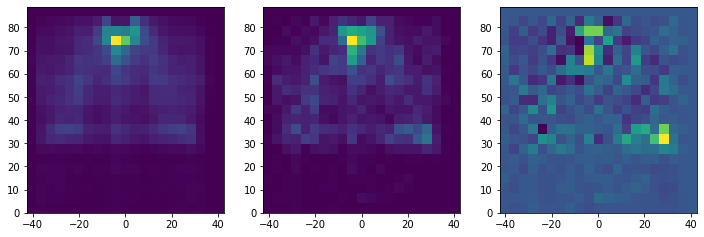

In [137]:
shots_hist2D_season, x_edge, y_edge = get_shots_hist2D(y_shots_season, 89-x_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)
shots_hist2D_season_by_hour = np.rot90(shots_hist2D_season_by_hour, k=1, axes=(1,0))


shots_hist2D_one_team, x_edge, y_edge = get_shots_hist2D(y_shots_one_team, 89-x_shots_one_team, num_pts_x=20, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / number_of_games_by_team
shots_hist2D_one_team_by_hour = np.rot90(shots_hist2D_one_team_by_hour, k=1, axes=(1,0))

diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour

fig, ax = plt.subplots(1, 3, figsize=(12,12))

# ax[0].imshow(shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[0, 89, -42.5, 42.5])
# ax[2].imshow(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, extent=[0, 89, -42.5, 42.5])

ax[0].imshow(shots_hist2D_season_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[1].imshow(shots_hist2D_one_team_by_hour, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
ax[2].imshow(diff, extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])
print(shots_hist2D_one_team_by_hour.max())
print(shots_hist2D_season_by_hour.max())
plt.show()


In [122]:
cd C:\\Users\\anniw\\IFT6758-A2022-G08\\notebooks

C:\Users\anniw\IFT6758-A2022-G08\notebooks


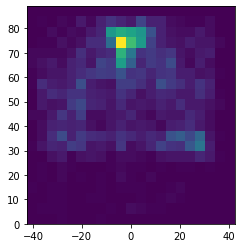

In [144]:
from PIL import Image

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(y_shots_season, 89-x_shots_season, num_pts_x=20, num_pts_y=20)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)
shots_hist2D_season_by_hour = np.rot90(shots_hist2D_season_by_hour, k=1, axes=(1,0))


shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(y_shots_one_team, 89-x_shots_one_team, num_pts_x=20, num_pts_y=20)
shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)
shots_hist2D_one_team_by_hour = np.rot90(shots_hist2D_one_team_by_hour, k=1, axes=(1,0))


plt.imshow(shots_hist2D_one_team_by_hour, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])
plt.show()

# shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.5)
# shots_hist2D_one_team_by_hour_s = gaussian_filter(shots_hist2D_one_team_by_hour, sigma = 1.5)

(21, 21)


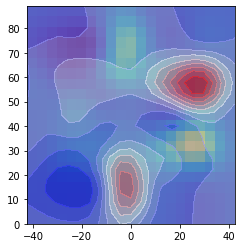

In [188]:
diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour
print(diff.shape)
# diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour
diff = gaussian_filter(diff, sigma = 1.5)
plt.imshow(diff, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]])
plt.contourf(x_grid, y_grid, diff, alpha=0.5, cmap='bwr', levels = np.linspace(diff.min(), diff.max(), 12), vmin=diff.min(), vmax=diff.max())
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])

plt.show()

In [185]:
rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height)).rotate(90, expand=True)
img = plt.imread(rink_half_img)
fig, ax = plt.subplots()
ax.imshow(img)

AttributeError: read

In [ ]:
import plotly.graph_objects as go

import numpy as np

x = np.random.uniform(-1, 1, size=500)
y = np.random.uniform(-1, 1, size=500)

fig = go.Figure(go.Histogram2dContour(
        x = x,
        y = y,
        colorscale = 'Blues'
))

fig.show()

(21, 21)


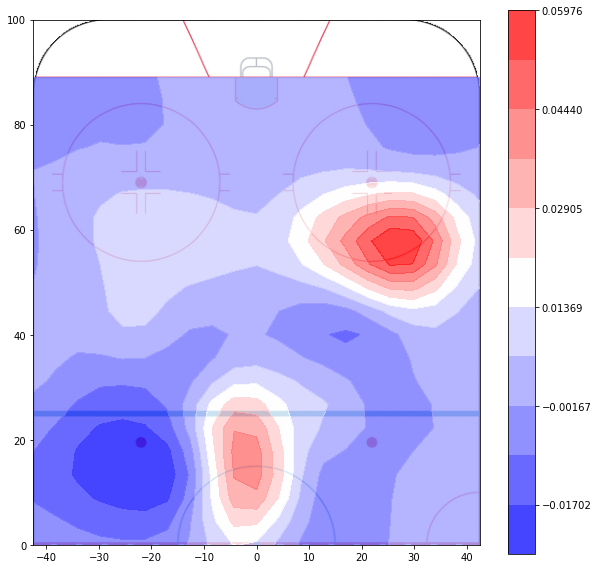

In [174]:
diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour
print(diff.shape)
# diff = shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour
diff = gaussian_filter(diff, sigma = 1.5)

# Not necessary
diff_min = diff.min()
diff_max = diff.max()
alpha = (-2./(diff_min-diff_max)) 
beta = (diff_min + diff_max) / (diff_min - diff_max)
diff_norm = alpha * diff + beta

# rink_img = (255 * mpimg.imread("./figures/nhl_rink.png")).astype(int)
# (h, w, c) = rink_img.shape
# rink_half_img = rink_img[:, int(w/2):, :]
# rink_half_img = ndimage.rotate(rink_half_img, 90).astype(int)
rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height)).rotate(90, expand=True)


fig = plt.figure(figsize=(10,10))
contour = plt.contourf(x_grid, y_grid, diff, alpha=0.8, cmap='bwr', levels = np.linspace(diff.min(), diff.max(), 12), vmin=diff.min(), vmax=diff.max())
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1])
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 0, 100])


# plt.contourf(y_grid, x_grid, diff_norm, alpha=0.8, cmap='bwr', levels = np.linspace(-1, 1, 20))

In [97]:
shots_hist2D_season_by_hour.max()

1.0255704169944926

In [98]:
np.sort(data_season_df['Team'].unique())

array(['Anaheim Ducks (ANA)', 'Arizona Coyotes (ARI)',
       'Boston Bruins (BOS)', 'Buffalo Sabres (BUF)',
       'Calgary Flames (CGY)', 'Carolina Hurricanes (CAR)',
       'Chicago Blackhawks (CHI)', 'Colorado Avalanche (COL)',
       'Columbus Blue Jackets (CBJ)', 'Dallas Stars (DAL)',
       'Detroit Red Wings (DET)', 'Edmonton Oilers (EDM)',
       'Florida Panthers (FLA)', 'Los Angeles Kings (LAK)',
       'Minnesota Wild (MIN)', 'Montréal Canadiens (MTL)',
       'Nashville Predators (NSH)', 'New Jersey Devils (NJD)',
       'New York Islanders (NYI)', 'New York Rangers (NYR)',
       'Ottawa Senators (OTT)', 'Philadelphia Flyers (PHI)',
       'Pittsburgh Penguins (PIT)', 'San Jose Sharks (SJS)',
       'St. Louis Blues (STL)', 'Tampa Bay Lightning (TBL)',
       'Toronto Maple Leafs (TOR)', 'Vancouver Canucks (VAN)',
       'Vegas Golden Knights (VGK)', 'Washington Capitals (WSH)',
       'Winnipeg Jets (WPG)'], dtype=object)

In [99]:
(shots_hist2D_season / (number_of_games*2)).max()

shots_hist2D_season, x_grid, y_grid = get_shots_hist2D(x_shots_season, y_shots_season, num_pts_x=15, num_pts_y=15)
shots_hist2D_season_by_hour = shots_hist2D_season / (number_of_games*2)
shots_hist2D_season_by_hour_s = gaussian_filter(shots_hist2D_season_by_hour, sigma = 1.5)

print(shots_hist2D_season_by_hour.max())

0.3296616837136113


In [100]:
df_diff = pd.DataFrame(index=data_season_df['Team'].unique(), columns=['Diff'])

teams = data_season_df['Team'].unique()

for team in teams:

   data_one_team_df = data_season_df.loc[data_season_df['Team'] == team]

   x_shots_one_team = data_one_team_df['st_X'].dropna().to_numpy().copy().astype(np.float32)
   y_shots_one_team = data_one_team_df['st_Y'].dropna().to_numpy().copy().astype(np.float32)

   shots_hist2D_one_team, x_grid, y_grid = get_shots_hist2D(x_shots_one_team, y_shots_one_team, num_pts_x=15, num_pts_y=15)
   shots_hist2D_one_team_by_hour = shots_hist2D_one_team / (number_of_games_by_team)
   shots_hist2D_one_team_by_hour_s = gaussian_filter(shots_hist2D_one_team_by_hour, sigma = 1.5)

   diff = gaussian_filter(shots_hist2D_one_team_by_hour-shots_hist2D_season_by_hour, 1.5)
   # diff = (shots_hist2D_one_team_by_hour_s-shots_hist2D_season_by_hour_s) / shots_hist2D_season_by_hour_s

   diff_min = diff.min()
   diff_max = diff.max()
   alpha = (-2./(diff_min-diff_max)) 
   beta = (diff_min + diff_max) / (diff_min - diff_max)
   diff_norm = alpha * diff + beta

   df_diff.loc[team]['Diff'] = diff_norm

df_diff = df_diff.sort_index()

print(df_diff.iloc[0]['Diff'].shape)


(16, 16)


In [101]:
max(y_grid)

89.0

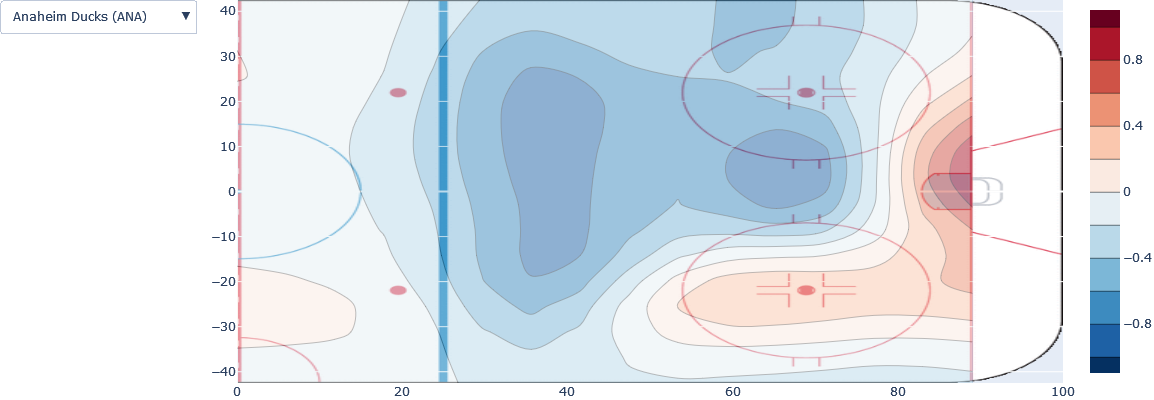

In [327]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
from PIL import Image

# load dataset

# Create figure
fig = go.Figure()


rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height))
# rink_half_img = rink_half_img.rotate(270, expand=1)

# Constants
img_width = 800
img_height = 800/2
scale_factor = 1.0

fig.add_trace(
    go.Contour(
        z=df_diff.iloc[0]['Diff'],
        # zmin=-1, zmax=1,
        x=x_grid,
        y=y_grid,
        colorscale="Rdbu", 
        reversescale=True,
        connectgaps=True,
        # zsmooth='best',
        opacity=0.5,
    )
)




updatemenu = []
buttons=[]
for team in df_diff.index.to_list():
    buttons.append(dict(method='restyle',
                        label=team,
                        args=[{
                               'z':[df_diff.loc[team]['Diff']],
                               'type': 'contour'}, [0]])
 
                  )

fig.add_layout_image(
    dict(
        x=0,
        sizex=100,
        y=42.5,
        sizey=42.5*2,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
)

fig.update_layout(
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
    #source=rink_half_img
)

fig.update_xaxes(
    # visible=True,
    showgrid=False,
    range=[0, 100])

fig.update_yaxes(
    # visible=True,
    # showgrid=False,
    # autorange="reversed",
    range=[-42.5, 42.5])                  




updatemenu=[]
your_menu=dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True


# update layout and show figure
fig.update_layout(updatemenus=updatemenu)


fig.show()

In [816]:
import plotly.graph_objects as go
import plotly.express as px

import pandas as pd
from PIL import Image

rink_img = Image.open("./figures/nhl_rink.png")
width, height = rink_img.size
rink_half_img = rink_img.crop((width/2, 0, width, height))
# rink_half_img = rink_half_img.rotate(270, expand=1)
# Constants
img_width = 800
img_height = 800/2
scale_factor = 1.0



layout = go.layout(
    xaxis = go.layout.XAxis(
        visible=False,
        showgrid=False,
        range=[0, 100]),
    yaxis = go.layout.YAxis(
        visible=False,
        showgrid=False,
        autorange="reversed",
        range=[-42.5, 42.5]),
    width=img_width * scale_factor,
    height=img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
    images = [dict(
        x=0,
        sizex=100,
        y=42.5,
        sizey=42.5*2,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
        ]
)

layout = go.Layout(
    xaxis = go.layout.XAxis(
        visible=False,
        showgrid=False,
        range=[0, 100]),
    yaxis = go.layout.YAxis(
        visible=False,
        showgrid=False,
        autorange="reversed",
        range=[-42.5, 42.5]),
    width = img_width*scale_factor,
    height = img_height*scale_factor,
    margin = {'l': 0, 'r': 0, 't': 0, 'b': 0},
    
    images =[dict(
        visible=True,
        x=0,
        sizex=img_width*scale_factor,
        y=img_height*scale_factor,
        sizey=img_height*scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
        ]

)




fig.add_trace(
    go.Contour(
        z=df_diff.iloc[0]['Diff'],
        # zmin=-1, zmax=1,
        x=x_grid,
        y=y_grid,
        colorscale="Rdbu", 
        reversescale=True,
        connectgaps=True,
        # zsmooth='best',
        opacity=0.5,
    )
)




updatemenu = []
buttons=[]
for team in df_diff.index.to_list():
    buttons.append(dict(method='restyle',
                        label=team,
                        args=[{
                               'z':[df_diff.loc[team]['Diff']],
                               'type': 'contour'}, [0]])
 
                  )


updatemenu=[]
your_menu=dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True

layout['updatemenus'] = updatemenu   


# update layout and show figure
fig.update_layout(updatemenus=updatemenu)

# Create figure
fig = go.Figure()


fig.show()

TypeError: 'module' object is not callable

In [819]:
import numpy as np
import plotly.graph_objs as go
import plotly as ply
from PIL import Image

img_width = 2560
img_height = 1920
scale_factor = 0.2

layout = go.Layout(
    xaxis = go.layout.XAxis(
        visible = False,
        range = [0, img_width*scale_factor]),
    yaxis = go.layout.YAxis(
        visible=False,
        range = [0, img_height*scale_factor],

        scaleanchor = 'x'),
    width = img_width*scale_factor,
    height = img_height*scale_factor,
    margin = {'l': 0, 'r': 0, 't': 0, 'b': 0},
    
    images =[dict(
        visible=True,
        x=0,
        sizex=img_width*scale_factor,
        y=img_height*scale_factor,
        sizey=img_height*scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=rink_half_img)
        ]

)
    
cluster0 = [dict(
            visible=True,
            x=0,
            sizex=img_width*scale_factor,
            y=img_height*scale_factor,
            sizey=img_height*scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=rink_half_img)]
cluster1 = [dict(
            visible=True,
            x=0,
            sizex=img_width*scale_factor,
            y=img_height*scale_factor,
            sizey=img_height*scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=rink_half_img)]
cluster2 = [dict(
            visible=True,
            x=0,
            sizex=img_width*scale_factor,
            y=img_height*scale_factor,
            sizey=img_height*scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=rink_half_img)]


    
updatemenus = list([
    dict(type="buttons",
         buttons=list([   
            dict(label = 'Image n',
                 method = 'relayout',
                 args = ['images', cluster0]),
            dict(label = 'Image n-1',
                 method = 'relayout',
                 args = ['images', cluster1]),
            dict(label = 'Image n-2',
                 method = 'relayout',
                 args = ['images', cluster2])
        ]),
    )
])
    
layout['updatemenus'] = updatemenus   
# we add a scatter trace with data points in opposite corners to give the Autoscale feature a reference point
fig = go.Figure(data=[{
    'x': [0, img_width*scale_factor], 
    'y': [0, img_height*scale_factor], 
    'mode': 'markers',
    'marker': {'opacity': 0}}],layout = layout)

ply.offline.plot(fig, filename='ImChalet',config={'showLink': False})

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "file:///mnt/d/GitHub/IFT6758-A2022-G08/notebooks/ImChalet.html ...
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


'ImChalet.html'

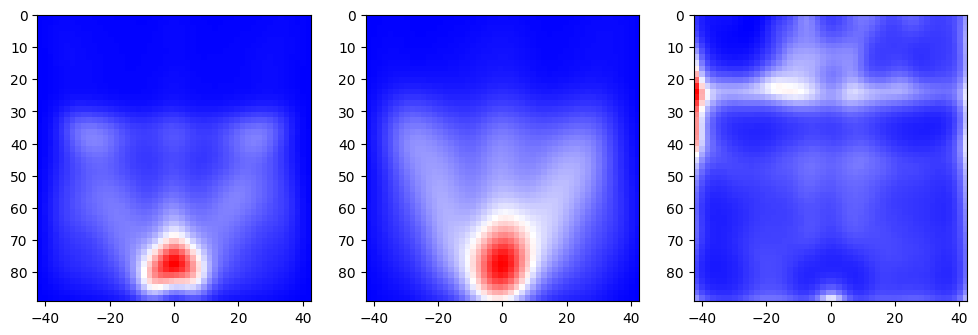

In [ ]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5


def get_kde(x_shots, y_shots):

   X, Y = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]
   positions = np.vstack([X.ravel(), Y.ravel()])
   values = np.vstack([x_shots, y_shots])
   kernel = stats.gaussian_kde(values)
   Z = np.reshape(kernel(positions).T, X.shape)

   return Z

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

kde_season = get_kde(x_shots_season, y_shots_season)
ax[0].imshow(kde_season, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[0].plot(y_shots_season, x_shots_season, 'k.', markersize=2)
ax[0].set_xlim([y_min, y_max])
ax[0].set_ylim([x_max, x_min])

kde_team = get_kde(x_shots_one_team, y_shots_one_team)
ax[1].imshow(kde_team, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[1].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[1].set_xlim([y_min, y_max])
ax[1].set_ylim([x_max, x_min])

kde_diff = (kde_team - kde_season) / kde_season
ax[2].imshow(kde_diff, cmap='bwr', extent=[y_min, y_max, x_max, x_min])
# ax[2].plot(y_shots_one_team, x_shots_one_team, 'k.', markersize=2)
ax[2].set_xlim([y_min, y_max])
ax[2].set_ylim([x_max, x_min])
plt.show()


In [ ]:
kde_diff.max()

9.771608159448833

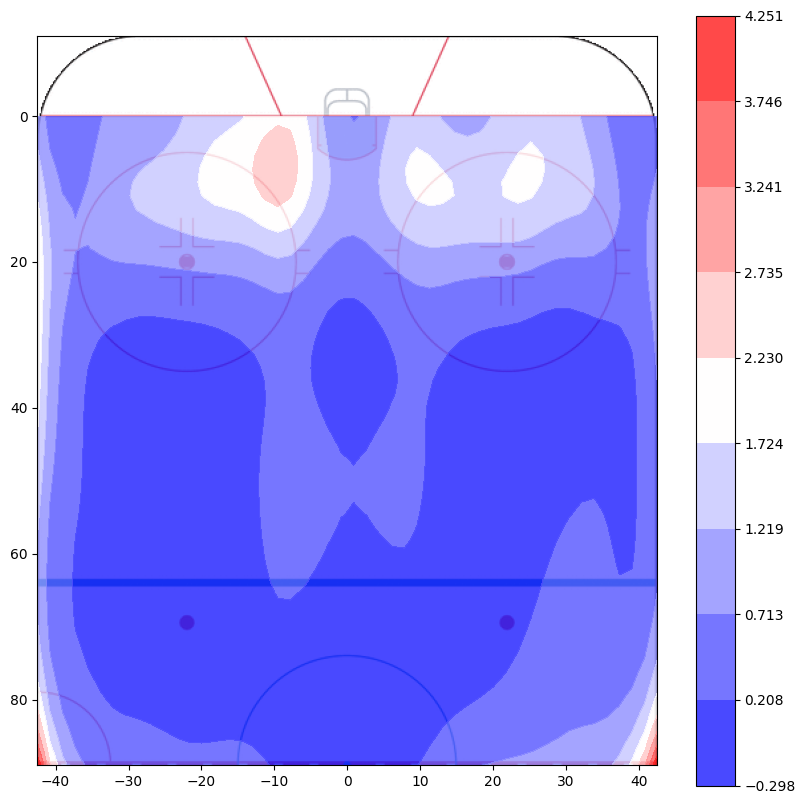

In [ ]:
x_min, x_max = 0, 89
y_min, y_max = -42.5, 42.5

y_grid, x_grid = np.mgrid[x_min:x_max:50j, y_min:y_max:50j]

fig = plt.figure(figsize=(10,10))
# plt.contourf(x_grid, y_grid, kde_season, alpha=0.8, cmap='bwr', levels = np.linspace(kde_season.min(), kde_season.max(), 10), vmin=kde_season.min(), vmax=kde_season.max())
plt.contourf(x_grid, y_grid, kde_diff, alpha=0.8, cmap='bwr', levels = np.linspace(kde_diff.min(), kde_diff.max(), 10), vmin=kde_diff.min(), vmax=kde_diff.max())
plt.colorbar(orientation = 'vertical')
plt.imshow(rink_half_img, extent=[-42.5, 42.5, 89, -11])